In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import lime
import time
import tensorflow.keras.preprocessing.image as tf_image
import splitfolders
import shutil
import random
import csv
import os,sys
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from skimage.io import imread
from IPython.display import Image
from skimage.segmentation import mark_boundaries
%load_ext autoreload
%autoreload 2

main_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
dataset_dir = os.path.join(main_dir, 'image_dataset')
dataset_dir_2 = os.path.join(main_dir, 'image_dataset_2')
train_dir = os.path.join(dataset_dir_2, 'train')
val_dir = os.path.join(dataset_dir_2, 'val')
test_dir = os.path.join(dataset_dir_2, 'test')

# splits the image dataset into 64% training, 16% validation, and 20% test sets into a new directory
def split_images():
    randNum = random.randint(0, 1337)
    if os.path.exists(dataset_dir_2):
        shutil.rmtree(dataset_dir_2)
    if not os.path.exists(dataset_dir_2):
        os.mkdir(dataset_dir_2)
    splitfolders.ratio(dataset_dir, output=dataset_dir_2, 
                       seed=randNum, ratio=(.64, .16, .2), 
                       group_prefix=None)
    return "Dataset splitting completed"

# saves the training record into csv file for comparison
def save_training_record(model_name, attempt):
    csv_path = os.path.join(main_dir, 'imageClassificationsComparisons.csv')
    csv_file = open(csv_path, 'a', newline='')
    wr = csv.writer(csv_file)
    wr.writerow([model_name, attempt, initial_epochs, earlystopping.stopped_epoch+1-initial_epochs, 
                 training_time, loss1*100, accuracy1*100, (60-compare_predictions_all())])
    csv_file.close()
    return "record saved in csv file successfully"

def compare_predictions_all():
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return count_all_wrong

# compare predictions against label batch in test dataset and count how many wrong predictions
def wrong_predictions_statistics(predictions, label_batch):
    count_all_wrong = 0
    count_acc_wrong = 0
    count_norm_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
        if label_list[i] == 0 and pred_list[i] == 1:
            count_acc_wrong += 1
        if label_list[i] == 1 and pred_list[i] == 0:
            count_norm_wrong += 1
    return print("Total Predictions Wrong: %d, Accidents Predictions Wrong: %d, Normal Predictions Wrong: %d" % 
                 (count_all_wrong, count_acc_wrong, count_norm_wrong))

# compare predictions against label batch in test dataset and count how many correct predictions
def correct_predictions_statistics(predictions, label_batch):
    count_all_correct = 0
    count_acc_correct = 0
    count_norm_correct = 0
    correct_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] == pred_list[i]:
            count_all_correct += 1
            correct_pred_list.append(i)
        if label_list[i] == 0 and pred_list[i] == 0:
            count_acc_correct += 1
        if label_list[i] == 1 and pred_list[i] == 1:
            count_norm_correct += 1
    return print("Total Predictions Correct: %d, Accidents Predictions Correct: %d, Normal Predictions Correct: %d" % 
                 (count_all_correct, count_acc_correct, count_norm_correct))

# Preprocess the image for explanation output
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf_image.load_img(img_path, target_size=(224, 224))
        x = tf_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        out.append(x)
    return np.vstack(out)

# Get the number of wrong predictions
def wrong_predictions_count(predictions, label_batch):
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return count_all_wrong

def correct_predictions_count(predictions, label_batch):
    count_all_correct = 0
    correct_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] == pred_list[i]:
            count_all_correct += 1
            correct_pred_list.append(i)
    return count_all_correct

# Function that returns all wrong prediction in a list
def wrong_predictions_list(predictions, label_batch):
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return wrong_pred_list

# Function that returns all correct prediction in a list
def correct_predictions_list(predictions, label_batch):
    count_all_correct = 0
    correct_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] == pred_list[i]:
            count_all_correct += 1
            correct_pred_list.append(i)
    return correct_pred_list

# Iterates through the test dataset and return a prediction
def dataset_numpy_iterator():
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = loaded_model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    return predictions, image_batch, label_batch

# Displays all wrong image predictions, used in get_wrong_image_predictions()      
def print_wrong_image_predictions(predictions, image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for i in range(wrong_predictions_count(predictions, label_batch)):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(image_batch[wrong_predictions_list(predictions, label_batch)[i]].astype("uint8"))
      plt.title(class_names[predictions[wrong_predictions_list(predictions, label_batch)[i]]])
      plt.axis("off")
        
# Displays all correct image predictions, used in get_correct_image_predictions()      
def print_correct_image_predictions(predictions, image_batch, label_batch):
    plt.figure(figsize=(15, 15))
    for i in range(correct_predictions_count(predictions, label_batch)):
      ax = plt.subplot(8, 8, i + 1)
      plt.imshow(image_batch[correct_predictions_list(predictions, label_batch)[i]].astype("uint8"))
      plt.title(class_names[predictions[correct_predictions_list(predictions, label_batch)[i]]])
      plt.axis("off")

    
# Function that displays wrong predictions info
def get_wrong_prediction_info():
    predictions, image_batch, label_batch = dataset_numpy_iterator()
        
    wrong_predictions_statistics(predictions, label_batch)
    
# Function that displays correct predictions info
def get_correct_prediction_info():
    predictions, image_batch, label_batch = dataset_numpy_iterator()
        
    correct_predictions_statistics(predictions, label_batch)

# Function that displays all wrong predictions
def get_wrong_image_predictions():
    predictions, image_batch, label_batch = dataset_numpy_iterator()
        
    print_wrong_image_predictions(predictions, image_batch, label_batch)
    
# Function that displays all correct predictions
def get_correct_image_predictions():
    predictions, image_batch, label_batch = dataset_numpy_iterator()
        
    print_correct_image_predictions(predictions, image_batch, label_batch)

In [2]:
#Splits the dataset
split_images()

Copying files: 291 files [00:00, 1182.66 files/s]


'Dataset splitting completed'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                           batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           batch_size=60,
                                                          image_size=IMG_SIZE)

Found 185 files belonging to 2 classes.
Found 46 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


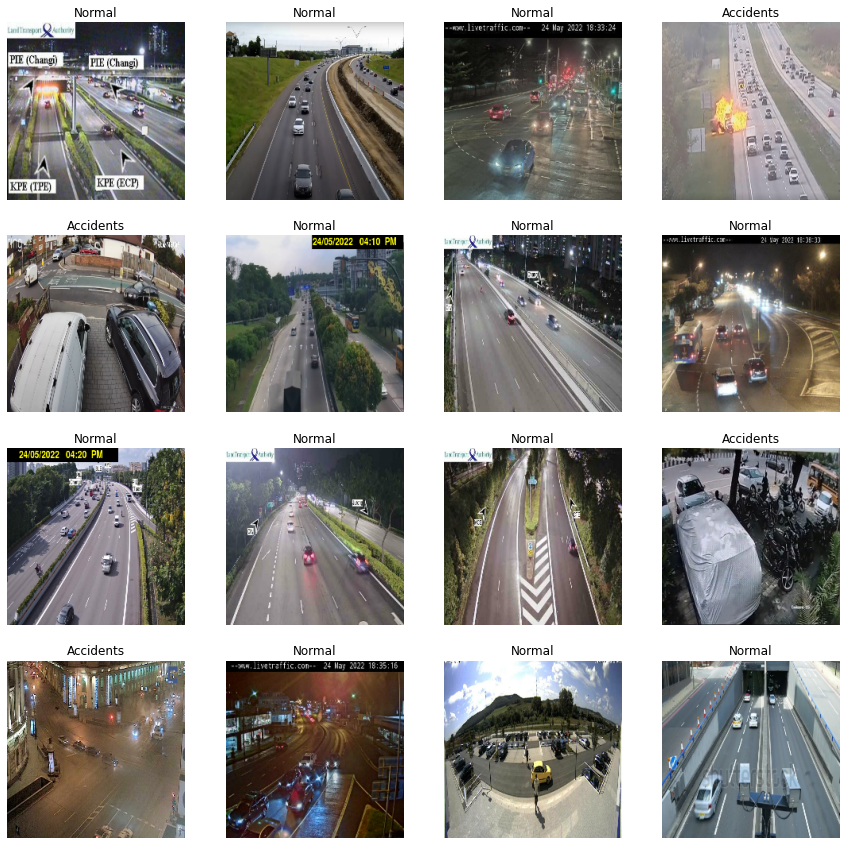

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the Dataset For Performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

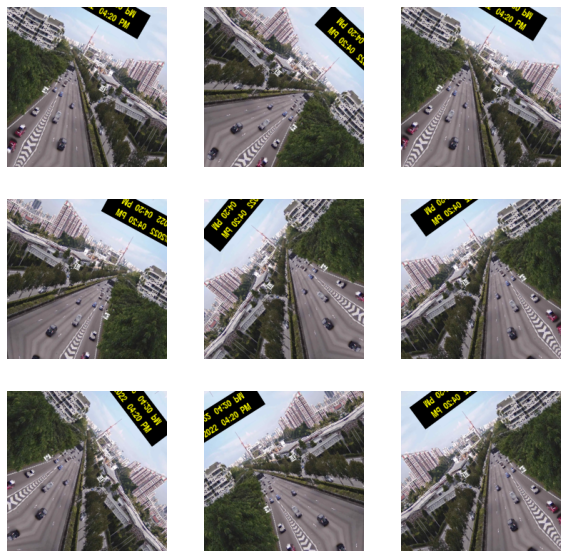

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescaling Pixel Values

# Creating Base Model from VGG19

In [7]:
# Create the base model from the pre-trained model VGG19
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 512)


In [8]:
### Freeze The Convolutional Base

base_model.trainable = False

In [9]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
### Add a classification head

#To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [11]:
# Keras Dense layer is added to convert features into a single predictions per image, 
# in which positive numbers predict class 1 (Normal Roads) and negative numbers predict
# no activation is required as predictions will be a logit or raw prediction value

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
#Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor 
#layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, 
#use `training=False` as our model contains a `BatchNormalization` layer.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Feature Extraction

In [13]:
### Compile the model

#Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` 
#loss with `from_logits=True` since the model provides a linear output.

base_learning_rate = 0.00012
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2

In [14]:
### Train the model with earlystopping callbacks to avoid overfitting the model. 
# Usually earlystopping will be called in the Fine Tuning phase instead of Feature Extraction

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

initial_epochs = 50

start_time = time.time()


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks =[earlystopping])



Epoch 1/50
6/6 [==============================] - 15s 2s/step - loss: 2.1058 - accuracy: 0.5027 - val_loss: 2.1852 - val_accuracy: 0.6957
Epoch 2/50
6/6 [==============================] - 14s 2s/step - loss: 1.9088 - accuracy: 0.5622 - val_loss: 2.1163 - val_accuracy: 0.6957
Epoch 3/50
6/6 [==============================] - 14s 2s/step - loss: 2.1000 - accuracy: 0.5405 - val_loss: 2.0163 - val_accuracy: 0.6957
Epoch 4/50
6/6 [==============================] - 14s 2s/step - loss: 1.4236 - accuracy: 0.5459 - val_loss: 1.9450 - val_accuracy: 0.6739
Epoch 5/50
6/6 [==============================] - 14s 2s/step - loss: 1.7814 - accuracy: 0.5027 - val_loss: 1.9108 - val_accuracy: 0.6957
Epoch 6/50
6/6 [==============================] - 14s 2s/step - loss: 1.6740 - accuracy: 0.5568 - val_loss: 1.8681 - val_accuracy: 0.6957
Epoch 7/50
6/6 [==============================] - 14s 2s/step - loss: 1.7409 - accuracy: 0.5405 - val_loss: 1.8284 - val_accuracy: 0.6957
Epoch 8/50
6/6 [==================

# Fine tuning

In [15]:
### Un-freeze the top layers of the model

#All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the 
#model (necessary for these changes to take effect), and resume training.

base_model.trainable = True

In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  22


In [17]:
### Compile the model

#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower 
#learning rate at this stage. Otherwise, your model could overfit very quickly.
ft_learning_rate = 0.000008

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=ft_learning_rate),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

28

In [18]:
### Continue training the model

#If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=(history.epoch[-1]+1),
                         validation_data=validation_dataset,
                         callbacks =[earlystopping])



Epoch 31/100
6/6 [==============================] - 44s 7s/step - loss: 1.1019 - accuracy: 0.6054 - val_loss: 0.4914 - val_accuracy: 0.8696
Epoch 32/100
6/6 [==============================] - 43s 7s/step - loss: 0.3939 - accuracy: 0.8216 - val_loss: 0.4126 - val_accuracy: 0.8913
Epoch 33/100
6/6 [==============================] - 45s 7s/step - loss: 0.3722 - accuracy: 0.8270 - val_loss: 0.4512 - val_accuracy: 0.8696
Epoch 34/100
6/6 [==============================] - 44s 7s/step - loss: 0.4023 - accuracy: 0.8378 - val_loss: 0.3879 - val_accuracy: 0.8261
Epoch 35/100
6/6 [==============================] - 45s 7s/step - loss: 0.4459 - accuracy: 0.8000 - val_loss: 0.3475 - val_accuracy: 0.8696
Epoch 36/100
6/6 [==============================] - 45s 7s/step - loss: 0.2885 - accuracy: 0.8703 - val_loss: 0.3320 - val_accuracy: 0.8696
Epoch 37/100
6/6 [==============================] - 45s 7s/step - loss: 0.3162 - accuracy: 0.8216 - val_loss: 0.3491 - val_accuracy: 0.8478
Epoch 38/100
6/6 [==

In [19]:
training_time = time.time() - start_time
print("--- %s seconds taken to train model ---" % (training_time))

acc = history.history['accuracy']
acc += history_fine.history['accuracy']

val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
loss += history_fine.history['loss']

val_loss = history.history['val_loss']
val_loss += history_fine.history['val_loss']

--- 1028.079600572586 seconds taken to train model ---


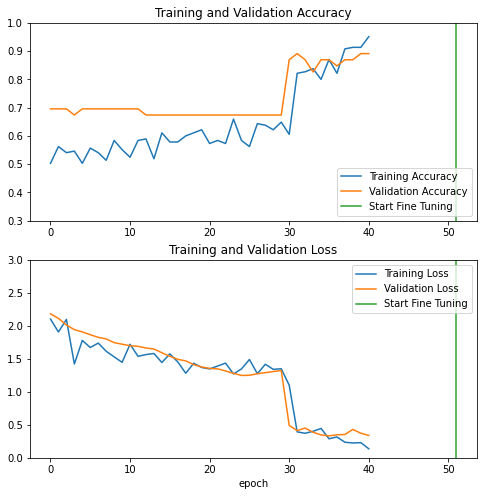

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs+1,initial_epochs+1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs+1,initial_epochs+1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
### Evaluation and prediction

#Finally you can verify the performance of the model on new data using test set.

loss1, accuracy1 = model.evaluate(test_dataset)
print("The test accuracy is {} and loss is {}".format(accuracy1, loss1))

1/1 [==============================] - 4s 4s/step - loss: 0.4460 - accuracy: 0.8667
The test accuracy is 0.8666666746139526 and loss is 0.4460328221321106


Predictions:
 [1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 0 1
 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1]
Labels:
 [1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 1 1
 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0]


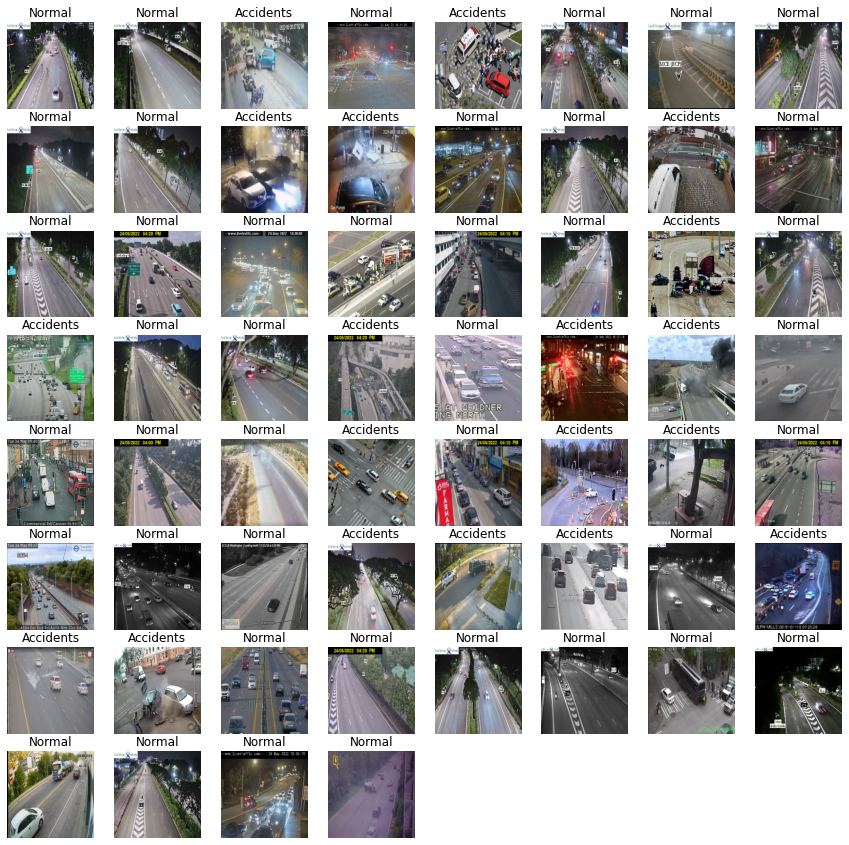

In [22]:
#And now you are all set to use this model to predict if your pet is a normal or accident.

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(60):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [23]:
compare_predictions()

Total Predictions Wrong: 11, Accidents Predictions Wrong: 7, Normal Predictions Wrong: 4


In [24]:


print("FE Epoch Undergo: ", initial_epochs)
print("FT Epoch Undergo: ", earlystopping.stopped_epoch+1 - initial_epochs)
print("Loss Percentage: %.2f" % (loss1*100))
print("Accuracy Percentage: %.2f" % (accuracy1*100))
print("Training Time %s seconds: " % (training_time))
print("Correct Predictions out of 60: ", (60-compare_predictions_all()))

save_training_record("VGG19", 2)

FE Epoch Undergo:  50
FT Epoch Undergo:  -9
Loss Percentage: 44.60
Accuracy Percentage: 86.67
Training Time 1028.079600572586 seconds: 
Correct Predictions out of 60:  49


'record saved in csv file successfully'

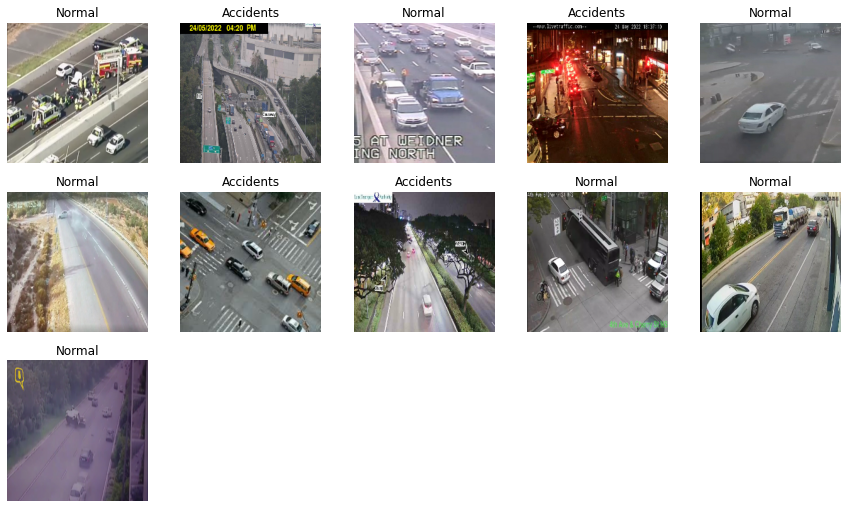

In [25]:
print_wrong_image_predictions()